In [1]:
using LightGraphs, RCall, Gadfly, Plots, LightGraphsFlows, PyPlot, DataFrames, Suppressor, CSV

In [3]:
include("code/BGSM_effective_resistance.jl");
include("code/model_selection.jl");
include("code/l0pen.jl");
@suppress begin
    R"library(genlasso); library(Matrix);";
end
using PyCall, Suppressor
@pyimport GraphSegment
@pyimport numpy
println("We import all relevant functions");

We import all relevant functions


In [4]:
m = 21;
x = linspace(-1,1,m); loc_x = repeat(x,inner = m);
y = linspace(-1,1,m); loc_y = repeat(y,outer = m);
Th = cos.(sqrt.(x.^2 .+ y'.^2) * pi/2);
Theta = 5 * ceil.(2.8 * Th - 0.2);
theta = Theta[:]; n = length(theta);
sigma = 1.0;
srand(1);
y = theta + sigma * randn(n); Y = reshape(y,21,21);
g = Grid([m;m]; periodic=false);
A = adjacency_matrix(g);
D = -full(incidence_matrix(g, oriented = true))';
R = effective_resistance(g,D);

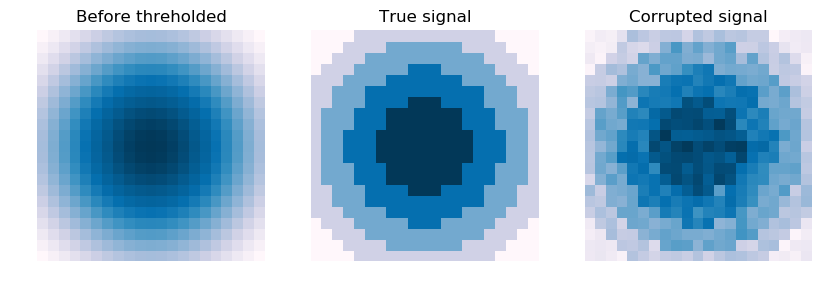

In [5]:
fig, ax = subplots(1,3,figsize = (10, 3))
ax[1][:pcolormesh](Th, cmap = "PuBu");
ax[1][:set_title]("Before threholded")
ax[1][:axis]("off");
ax[2][:pcolormesh](Theta, cmap = "PuBu");
ax[2][:axis]("off");
ax[2][:set_title]("True signal")
ax[3][:pcolormesh](Y, cmap = "PuBu");
ax[3][:axis]("off");
ax[3][:set_title]("Corrupted signal");

In [6]:
g = Grid([m;m]; periodic=false);
A = adjacency_matrix(g);
D = -full(incidence_matrix(g, oriented = true))';
n = m^2;
R = effective_resistance(g,D);

In [7]:
function sim_BGSM(y, D, theta)
    # Set v0_range
    v0_range = 1e-3 * [1;5;10;15;20;25;100];

    # Store final estimates and model selection scores
    mse = zeros(7,2);
    score = zeros(7);
    res = zeros(7,n);
    res2 = zeros(7,n);

    # Start loop
    for i = 1:7
        v0 = v0_range[i];
        out = BGSM_effective_resistance(y,D,R, v0 = v0, iter = 50, v1 = 1e4, verbose = false);
        out_ms = model_selection(out);
        res[i,:] = out[:theta] + out[:alpha];
        res2[i,:] = out_ms[:t_full];
        mse[i,1] = norm(out[:theta] + out[:alpha] - theta)^2/n;
        mse[i,2] = norm(out_ms[:t_full] - theta)^2/n;
        score[i] = out_ms[:score];
    end
    
    minind = findmin(score)[2];
    delta_hat = find(abs.(D*(res2[minind,:][:])) .> 1e-8);
    delta_true = find(abs.(D*theta) .> 1e-8);
    tp = length(findin(delta_hat,delta_true));
    fp = length(delta_hat) - tp;
    tn = length(delta_true) - tp;
    
    
    return Dict([
                (:minmse, mse[minind]), (:mse, mse), (:score,score), (:res, res), (:res2, res2),
                (:minind, minind),
                (:fp, fp), (:tn, tn), (:tp, tp)
                ])
end

function sim_genlasso(y, D, theta)
    @rput y; @rput D;
    @suppress begin
        R"D = Matrix(D, sparse = TRUE); n = length(y); out = genlasso(y, diag(n), D);";
        R"b = out$beta";
    end
    @rget b;
    mse_fl = sum((theta .- b).^2,1)[:]/n;
    mse, minind = findmin(mse_fl);
    delta_true = abs.(D*theta) .> 1e-8;
    maxind = findmax(sum((abs.(D*b) .> 1e-8) .& delta_true, 1))[2]
    b = b[:,maxind];
    delta_true = find(delta_true);
    delta_hat = find(abs.(D*b) .> 1e-8);
    tp = length(findin(delta_hat,delta_true));
    fp = length(delta_hat) - tp;
    tn = length(delta_true) - tp;
    return Dict([
                (:maxind, maxind), (:minind, minind), (:mse, mse_fl), (:minmse, mse),
                (:fp, fp), (:tn, tn), (:tp, tp)
                ])
end

function sim_l0pen(y, g, theta)
    
    n = length(y);
    mse = zeros(10);
    fp = zeros(10);
    tp = zeros(10);
    tn = zeros(10);
    b = zeros(n,10);
    
    for i = 1:10
        b[:,i] = local_minimizer(y,g, lambda = 5 * i, delta = 1);
        delta_true = find(abs.(D*theta) .> 1e-8);
        delta_hat = find(abs.(D*b) .> 1e-8);
        tp[i] = length(findin(delta_hat,delta_true));
        fp[i] = length(delta_hat) - tp[i];
        tn[i] = length(delta_true) - tp[i];
    end
    
    mse = sum((y .- b).^2,1)[:]/n;
    minmse, minind = findmin(mse);
    
    return Dict([
                (:minind, minind), (:mse, mse), (:minmse, mse[minind]),
                (:fp, fp[minind]), (:tn, tn[minind]), (:tp, tp[minind])
                ])
end

sim_l0pen (generic function with 1 method)

In [8]:
function sim(Th, g, D)
    mse = zeros(10,3); fp = zeros(10,3); tn = zeros(10,3);
    
    for i = 1:1
        Theta = i * ceil.(2.8 * Th - 0.2);
        theta = Theta[:]; n = length(theta);
        sigma = 1.0;
        srand(1);
        y = theta + sigma * randn(n); Y = reshape(y,21,21);
        out_bgsm = sim_BGSM(y, D, theta);
        println("bsgm done");
        out_genlasso = sim_genlasso(y, D, theta);
        println("genlasso_done");
        out_l0pen = sim_l0pen(y, g, theta);
        println("l0pen done");
        mse[i,1] = out_bgsm[:minmse];
        mse[i,2] = out_genlasso[:minmse];
        mse[i,3] = out_l0pen[:minmse];
        fp[i,1] = out_bgsm[:fp]; tn[i,1] = out_bgsm[:tn];
        fp[i,2] = out_genlasso[:fp]; tn[i,2] = out_genlasso[:tn];
        fp[i,3] = out_l0pen[:fp]; tn[i,3] = out_l0pen[:tn];
    end
    
    return Dict([(:mse, mse), (:fp, fp), (:tn, tn)])
end

sim (generic function with 1 method)

In [9]:
out = sim(Th, g, D);

bsgm done
genlasso_done
l0pen done


In [62]:
r1 = DataFrame(x = repeat(2:10, outer = 3), fp = out[:fp][2:end,:][:],
    tn = out[:tn][2:end,:][:], mse = out[:mse][2:end,:][:],
    method = repeat(["BGSM","GenLasso","L0Pen"], inner = 9));
p =  Gadfly.plot(r1, x = :x, y = :mse, color = :method, shape = :method, Geom.line, Geom.point,
         Scale.y_log10, Coord.cartesian(xmin = 1),
         Guide.title("mean squared error"), Guide.xlabel("signal strength"), Guide.ylabel("mse"))
p1 = Gadfly.plot(r1, x = :x, y = :fp, color = :method, shape = :method, Geom.line, Geom.point,
         Coord.cartesian(xmin = 1),
         Guide.title("false discoverie rate"), Guide.xlabel("signal strength"), Guide.ylabel("false discoveries"))
p2 = Gadfly.plot(r1, x = :x, y = :tn, color = :method, shape = :method, Geom.line, Geom.point,
         Coord.cartesian(xmin = 1, ymax = 100),
         Guide.title("true negatives"), Guide.xlabel("signal strength"), Guide.ylabel("true negatives"));
set_default_plot_size(40cm, 13cm)
F10 = Gadfly.title(hstack(p, p1, p2),"2d grid graph")
Gadfly.draw(PDF("F10.pdf"), F10);

In [49]:
CSV.write("result/2dimgrid1.txt", df, delim = ',');

In [63]:
p =  Gadfly.plot(r1, x = :x, y = :mse, color = :method, shape = :method, Geom.line, Geom.point,
         Scale.y_log10, Coord.cartesian(xmin = 1),
         Guide.title("mean squared error"), Guide.xlabel("signal strength"), Guide.ylabel("mse"))
p1 = Gadfly.plot(r1, x = :x, y = :fp, color = :method, shape = :method, Geom.line, Geom.point,
         Coord.cartesian(xmin = 1),
         Guide.title("false discoverie rate"), Guide.xlabel("signal strength"), Guide.ylabel("false discoveries"))
p2 = Gadfly.plot(r1, x = :x, y = :tn, color = :method, shape = :method, Geom.line, Geom.point,
         Coord.cartesian(xmin = 1, ymax = 100),
         Guide.title("true negatives"), Guide.xlabel("signal strength"), Guide.ylabel("true negatives"));
set_default_plot_size(40cm, 13cm)
F10 = Gadfly.title(hstack(p, p1, p2),"2d grid graph");

In [95]:
# sample data
m = 21;
x = linspace(-1,1,m); loc_x = repeat(x,inner = m);
y = linspace(-1,1,m); loc_y = repeat(y,outer = m);
Th = cos.(sqrt.(x.^2 .+ y'.^2) * pi/2);
Theta = 5 * ceil.(2.8 * Th - 0.2);
theta = Theta[:]; n = length(theta);
sigma = 1.0;
srand(1);
y = theta + sigma * randn(n); Y = reshape(y,m,m);
g = Grid([m;m]; periodic=false);
A = adjacency_matrix(g);
D = -full(incidence_matrix(g, oriented = true))';
R = effective_resistance(g,D);

# Set v0_range
v0_range = 1e-3 * [1;5;10;25;60;80;90];

# Store final estimates and model selection scores
res = zeros(21,21,7)
model_score = zeros(7);

# Start loop
for i = 1:7
    v0 = v0_range[i];
    out = BGSM_effective_resistance(y,D,R, v0 = v0, iter = 50, v1 = 1e4, verbose = false);
    ms = model_selection(out);
    res[:,:,i] = reshape(ms[:t_full],21,21)
    model_score[i] = ms[:score]
end

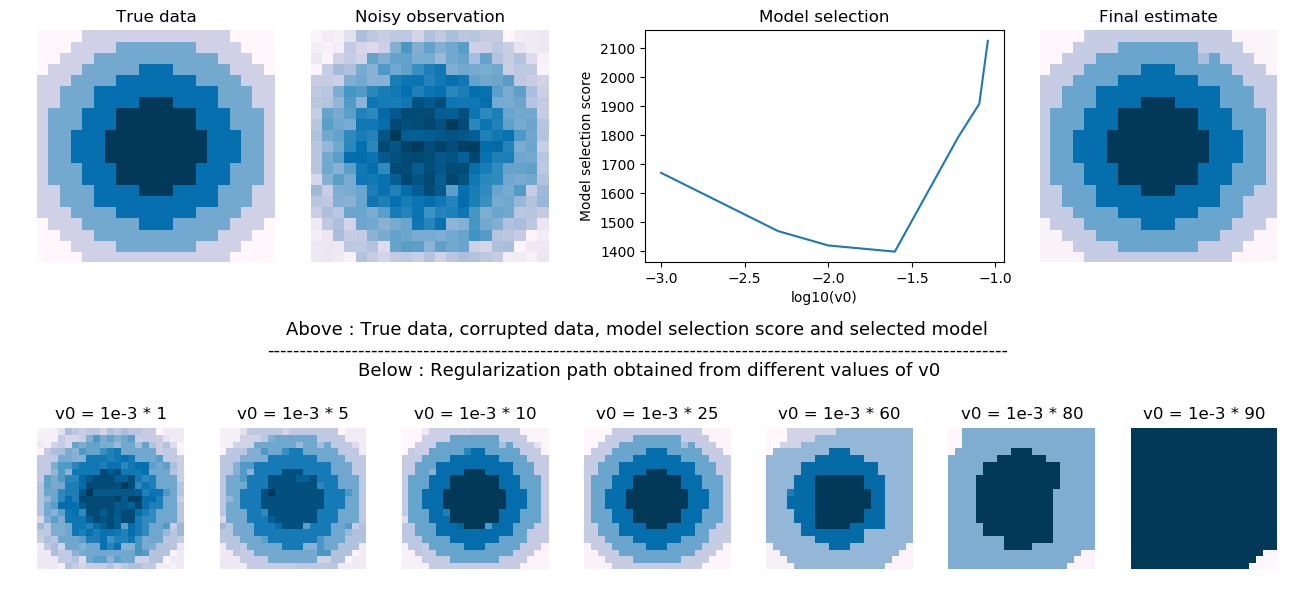

In [96]:
fig, axs = subplots(2,6, figsize = (16, 7))

suptitle("Above : True data, corrupted data, model selection score and selected model
------------------------------------------------------------------------------------------------------------------
    Below : Regularization path obtained from different values of v0",
    x = 0.5, y = 0.465, fontsize = 13)

axs[1] = subplot2grid((30,41), (0,0), rowspan = 13, colspan = 8)
axs[1][:pcolormesh](Theta,cmap = "PuBu")
axs[1][:set_title]("True data")
axis("off")

axs[2] = subplot2grid((30,41), (0,9), rowspan = 13, colspan = 8)
axs[2][:pcolormesh](Y,cmap = "PuBu")
axs[2][:set_title]("Noisy observation")
axis("off")

axs[10] = subplot2grid((30,41), (0,20), rowspan = 13, colspan = 12)
axs[10][:plot](log10.(v0_range[1:7]), model_score[1:7])
xlabel("log10(v0)");
ylabel("Model selection score")
axs[10][:set_title]("Model selection")

axs[11] = subplot2grid((30,41), (0,33), rowspan = 13, colspan = 8)
axs[11][:pcolormesh](res[:,:,findmin(model_score[1:7])[2]], cmap = "PuBu")
axs[11][:set_title]("Final estimate")
axis("off");

for i = 1:7
    axs[i+2] = subplot2grid((30,41), (22,i*6-6), rowspan = 8, colspan = 5)
    axs[i+2][:pcolormesh](res[:,:,i],cmap = "PuBu")
    v0 = Int(v0_range[i] * 10^3)
    axs[i+2][:set_title]("v0 = 1e-3 * $v0")
    axis("off")
end

PyPlot.savefig("figure/F20.pdf")

In [97]:
df2 = DataFrame(y = res[:])
df3 = DataFrame(y = model_score)
df4 = DataFrame(y = y, theta = theta)
CSV.write("result/2dimgrid2.txt", df2, delim = ',');
CSV.write("result/2dimgrid3.txt", df3, delim = ',');
CSV.write("result/2dimgrid4.txt", df4, delim = ',');

In [7]:
using PyCall, Suppressor
@pyimport GraphSegment
@pyimport numpy

In [10]:
edges = GraphSegment.Edges_2D(21,21);
eff   = GraphSegment.EffectiveResistance(edges);
B     = 5;
err   = zeros(10, B);
out_l0pen = 0;
srand(1);
for b = 1:B
    println(b);
    for i = 1:10
    @suppress begin
        out_l0pen = GraphSegment.GraphSegment(y,edges, 2.0^(i-4), weights = eff);
        sigma     = 1;
        alpha     = 0.2;
        z         = alpha * sigma * randn(n);
        y1        = y + z;
        y2        = y - z/alpha^2;
        mu1       = GraphSegment.GraphSegment(y1,edges, 2.0^(i-4), weights= eff);
        err[i,b]  = norm(y2 - mu1)^2/n;
        end;
    end
end

1
2
3
4
5


In [112]:
df = DataFrame(l0pen = out_l0pen, l0pen2 = out_l0pen2, genlasso = b[:,780], genlasso2 = b[:,670],
            y = y);
CSV.write("result/2dimgrid5.txt", df, delim = ',');

In [88]:
score = sum(err, 2);
minind = findmin(score)[2]
@suppress begin
    out_l0pen = GraphSegment.GraphSegment(y,edges, 2.0^(minind - 4), delta=.01);
end;
out_l0pen2 = GraphSegment.GraphSegment(y,edges, 2.0^(8 - 4), delta=.01);;

In [9]:
out_genlasso = 0;
@suppress begin
    out_genlasso = sim_genlasso(y, D, theta)
end

Dict{Symbol,Any} with 7 entries:
  :tn     => 5
  :minind => 780
  :mse    => [34.5484, 34.5484, 34.5484, 34.5484, 34.5484, 34.5484, 34.5484, 34…
  :fp     => 255
  :tp     => 199
  :maxind => 582
  :minmse => 0.58403

In [36]:
k = zeros(1182)
for i = 1:1182
    k[i] = length(unique(round.(b[:,i] * 10000)))
end
z = 2 * log(m) * k + n * log.(sum((y .- b).^2,1)[:])
PyPlot.plot(z); findmin(z)[2]

In [94]:
out_l0pen2 = GraphSegment.GraphSegment(y,edges, 2.0^(6 - 4), delta=.01);

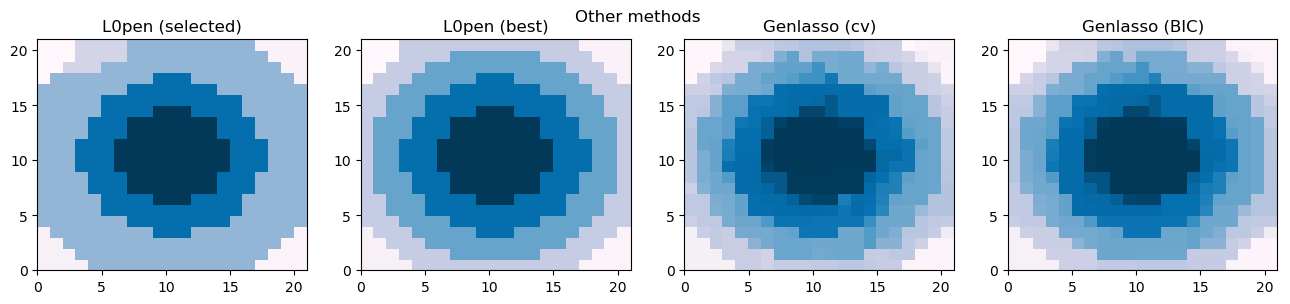

In [108]:
## draw plot
fig, axs = subplots(1,4, figsize = (16, 3))
subplot(141)
pcolormesh(reshape(out_l0pen,m,m), cmap = :PuBu)
PyPlot.title("L0pen (selected)")
subplot(142)
pcolormesh(reshape(out_l0pen2,m,m), cmap = :PuBu, )
PyPlot.title("L0pen (best)")
subplot(143)
pcolormesh(reshape(b[:,780],m,m), cmap = :PuBu)
PyPlot.title("Genlasso (cv)")
subplot(144)
pcolormesh(reshape(b[:,670],m,m), cmap = :PuBu)
PyPlot.title("Genlasso (BIC)")

suptitle("Other methods")
PyPlot.savefig("figure/temp10.pdf")